# Touristic Tour Recommendation Application
This notebook outlines the steps involved in creating an algorithm that generates a one-week itinerary for tourists in Algeria. The itinerary is optimized based on user preferences, proximity, and travel costs. Various search techniques, including **Uninformed Search Algorithms**, **A*** and **Hill Climbing**, are employed to create the optimal itinerary.


## Data Collection & Research
We gathered - clean - data about **+200 Algerian tourist attractions**, including the following attributes:
- **Attraction Name**
- **Type of Attraction** (museum, nature, beach, etc.)
- **City**
- **Cost** (entry fee)
- **Rating** (user rating)
- **GPS Coordinates** (latitude, longitude)
- **Description** (short description)


In [11]:
import json
from collections import Counter

DATA_PATH = "../Data/attractions.json"

with open(DATA_PATH, "r", encoding="utf-8") as f:
    attractions_data = json.load(f)
    

if not isinstance(attractions_data, list):
    raise ValueError("The JSON file does not contain a list of attractions.")

print("Number of attractions:", len(attractions_data))

# Count attractions per city
city_counts = Counter(attraction.get("city", "Unknown") for attraction in attractions_data)

# Count attractions per category
category_counts = Counter(attraction.get("category", "Unknown") for attraction in attractions_data)

print("\nNumber of attractions per city:")
for city, count in city_counts.items():
    print(f"{city}: {count}")

print("\nNumber of attractions per category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")


Number of attractions: 264

Number of attractions per city:
Algiers: 19
Tipaza: 5
Blida: 5
Médéa: 3
Oran: 17
Tlemcen: 9
Batna: 6
Béjaïa: 18
Constantine: 11
Djanet: 8
Sétif: 13
Annaba: 9
Guelma: 3
El Tarf: 7
Ghardaïa: 7
Tamanrasset: 7
Béchar: 3
Bouira: 7
El Bayadh: 1
Khenchela: 2
Biskra: 4
Timimoun: 6
El Oued: 2
M'Sila: 6
Tizi Ouzou: 21
Skikda: 6
Souk Ahras: 6
Tébessa: 6
Oum El-Bouaghi: 5
Jijel: 19
Aïn Témouchent: 10
Boumerdès: 5
Djelfa: 3
Naâma: 1
Mostaganem: 4

Number of attractions per category:
Garden: 5
Museum: 13
Cultural: 26
Historical: 50
Religious: 17
Amusement Park: 10
Shopping Mall: 6
Port: 2
Nature: 95
Lake: 6
Resort: 4
Beach: 30


## Data Hotel Collection & Research

We gathered and cleaned data about **+300 Algerian hotels** .  
This dataset contains valuable information to support various tasks such as:

- Recommendation systems
- Price analysis
- User satisfaction predictions

The dataset includes the following attributes:

- **Hotel Name**
- **City**
- **Price** (in DZD)
- **Average Review** (user rating)
- **GPS Coordinates** (latitude and longitude)

### Key Points
- **Cities covered**: Major Algerian cities and important tourist regions.
- **Price Range**: 4,000 DZD to 24,000 DZD per night.
- **Ratings Range**: 2.4 ★ to 5.0 ★.




In [12]:
import json
from collections import Counter

HOTELS_PATH = "../Data/cleaned_hotels.json"

with open(HOTELS_PATH, "r", encoding="utf-8") as f:
    hotels_data = json.load(f)

# Extract all city names
cities = [hotel['city'] for hotel in hotels_data]

# Count how many hotels per city
city_counts = Counter(cities)

# Display the results
for city, count in city_counts.items():
    print(f"{city}: {count} hotels")

# Total number of hotels
print(f"\nTotal number of hotels: {sum(city_counts.values())}")


Algiers: 59 hotels
Annaba: 43 hotels
Batna: 27 hotels
Béjaïa: 44 hotels
Constantine: 20 hotels
Ghardaïa: 21 hotels
Oran: 64 hotels
Sétif: 29 hotels
Tipasa: 7 hotels
Tlemcen: 31 hotels
Jijel: 14 hotels
Médéa: 10 hotels
Tipaza: 11 hotels
Biskra: 19 hotels
Khenchela: 10 hotels
El Bayadh: 7 hotels
Bouira: 11 hotels

Total number of hotels: 427



## 1. Hotel Selection Logic

Hotels are dynamically suggested based on:

- **Proximity to Attractions**: For each day of the itinerary, hotels are filtered by the city of the first attraction visited that day.
- **Budget Constraints**: The remaining budget (after attraction costs) is distributed evenly across nights to determine the maximum allowable price per hotel.
- **User Preferences**: Hotels are ranked by rating and price, with options filtered by the user’s preferred star range (e.g., 3–5 stars).

## 2. Implementation Workflow

**Step 1: Identify Cities Visited**  
Extract all unique cities from the itinerary’s attractions to determine where hotels are needed.

**Step 2: Calculate Budget**
```python
remaining_budget = total_budget - spent_cost
max_price_per_night = remaining_budget / 7  # Distribute budget over 7 nights
```

**Step 3: Filter and Rank Hotels**  
For each city, select hotels that:
- Match the user’s star preference.
- Are within `max_price_per_night`.
- Sorted by rating (descending) then price (ascending).

**Step 4: Display Recommendations**  
Top 3–5 hotels per city are displayed, with details (name, price, rating).

## 4. Example Output
```plaintext
🏨 Hotel Recommendations for Day 1 (Algiers):
1. Grand Hôtel des étrangers 
   ★ Rating: 5.0 | 💰 Price: 9,900 DZD/night
2. Hôtel Saint Eugène 
   ★ Rating: 4.7 | 💰 Price: 15,255 DZD/night
```

## 4. Key Methods

- `find_hotels_for_itinerary()`: Main function to map hotels to itinerary days.
- `suggest_hotels()`: Node method that calls the above and attaches results to the state.

## 5. Constraints Handled

- **Budget**: Hotels never exceed the remaining budget after attractions.
- **Time**: Assumes hotels are booked for the night after daily activities.
- **Preferences**: Honors the user’s minimum/maximum star rating.

## 6. Integration Notes

- Hotels are not included in the itinerary’s total cost by default (marked separately).


## Problem Formulation
### 1. State Representation

Our state representation is a dictionary with the following structure:

```python
state = {
    'current_location': (lat, lon),         # Current GPS coordinates
    'itinerary': [[] for _ in range(7)],    # 7 days of planned attractions (names)
    'curr_day': 0,                          # Current day index (0-6)
    'total_cost': 0,                        # Accumulated cost so far
    'total_time': 0,                        # Total travel time
    'daily_time': [0]*7                     # Time used per day (including visits)
    'daily_distance' : [0.0]*7
}
```

### 2. Actions

Two possible actions:
1. `('add', attraction)`: Add an attraction to the current day
2. `('next_day',)`: Move to the next day of planning

### 3. Goal Test

The goal is reached when:
- All 7 days have been planned (`curr_day >= 7`)
- Each day has at least one attraction

### 4. Path Cost

The path cost is the cumulative cost of visiting attractions and traveling between them.

### Problem Class
Now, let's define the main Problem class that will encapsulate our tour planning problem

In [13]:
import math
import json
import random
import re
from copy import deepcopy
from typing import List, Dict, Tuple  # Helper library for type hinting

class TourPlanningProblem:
    def __init__(self, initial_state: Dict, attractions: List[Dict],
                 user_prefs: Dict, constraints: Dict):
        """
        Args:
            initial_state: Initial state dictionary.
            attractions: List of attraction dictionaries.
            user_prefs: User preferences dictionary.
            constraints: Problem constraints dictionary.
        """
        self.initial_state = initial_state
        self.attractions = attractions
        self.user_prefs = user_prefs
        self.constraints = constraints

        # cheaper if the user has a car
        self.dzd_per_km = 6.0 if constraints.get("has_car", False) else 10.0

        self.distance_cache = self._build_distance_cache()

    def _build_distance_cache(self) -> Dict[Tuple[str, str], float]:
        """Precompute distances between all pairs of attractions.
            store only upper‑triangle to halve the size"""
        cache = {}
        names = [a['name'] for a in self.attractions]
        for i, a1 in enumerate(self.attractions):
            for j in range(i + 1, len(self.attractions)):
                a2 = self.attractions[j]
                d = self._calculate_distance(a1['gps'], a2['gps'])
                cache[(a1['name'], a2['name'])] = d
                cache[(a2['name'], a1['name'])] = d          # mirror
        return cache

    @staticmethod
    def _calculate_distance(coord1: List[float], coord2: List[float]) -> float:
        """
        Haversine distance (km) between two GPS coordinates.
        """
        lat1, lon1 = map(math.radians, coord1)
        lat2, lon2 = map(math.radians, coord2)
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = (math.sin(dlat / 2)**2 +
             math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2)
        return 6371 * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    def actions(self, state: Dict) -> List[Tuple]:
        """
        Return a list of possible actions from the current state.
        Two types of actions:
          - ('add', <attraction_dict>): add an attraction to the current day.
          - ('next_day',): move to the next day.
        """
        valid_actions = []
        curr_day = state['curr_day']

        # If all days are planned, no further actions
        if curr_day >= len(state['itinerary']):
            return []

        # If the current day is full, only allow moving to next day
        if len(state['itinerary'][curr_day]) >= self.constraints['max_attractions_per_day']:
            return [('next_day',)]

        preferred = set(self.user_prefs.get('categories', []))

        # Check each attraction for validity
        for att in self.attractions:
            if att['category'] not in preferred:                 # ← preference filter
                continue
            if self._is_valid_addition(state, att):
                valid_actions.append(('add', att))

        # Allow 'next_day' if there's at least one attraction in the current day
        if len(state['itinerary'][curr_day]) > 0:
            valid_actions.append(('next_day',))

        return valid_actions

    def _is_valid_addition(self, state: Dict, attraction: Dict) -> bool:
        curr_day = state['curr_day']
        if curr_day >= 7:
            return False

        # 1) duplicates & per-day limit
        if any(attraction['name'] in day for day in state['itinerary']):
            return False
        if len(state['itinerary'][curr_day]) >= self.constraints['max_attractions_per_day']:
            return False

        # 2) compute travel / visit metrics once
        distance_km  = self._calculate_distance(state['current_location'], attraction['gps'])
        travel_time  = distance_km / 50          # ← avg 50 km/h
        visit_time   = self._parse_duration(attraction['visit_duration'])
        ticket_cost  = self._parse_cost(attraction['cost'])
        travel_cost  = self.travel_cost_km(state['current_location'], attraction['gps'])

        # 3) global budget cap  (✓ Bug 2.1 fixed)
        budget_cap = self.constraints.get("max_total_budget")
        if budget_cap is not None:
            prospective = state['total_cost'] + ticket_cost + travel_cost
            if prospective > budget_cap:
                return False

        # 4) daily time cap
        if state['daily_time'][curr_day] + travel_time + visit_time > self.constraints['max_daily_time']:
            return False

        # 5) optional daily-distance cap  (✓ Bug 2.2 fixed)
        max_dist = self.constraints.get("max_daily_distance")
        if max_dist is not None:
            if state['daily_distance'][curr_day] + distance_km > max_dist:
                return False

        return True

    def _estimate_travel_time(self, state: Dict, new_attraction: Dict) -> float:
        """
        Estimate travel time from the last visited attraction (or current location)
        to the new attraction.
        Assumes an average speed of 50 km/h.
        """
        curr_day = state['curr_day']
        day_attractions = state['itinerary'][curr_day]

        if not day_attractions:
            last_coords = state['current_location']
        else:
            last_att_name = day_attractions[-1]
            last_att = next(a for a in self.attractions if a['name'] == last_att_name)
            last_coords = last_att['gps']

        distance = self._calculate_distance(last_coords, new_attraction['gps'])
        return distance / 50  # hours

    def result(self, state: Dict, action: Tuple) -> Dict:
        new_state = deepcopy(state)
        action_type = action[0]
        curr_day = new_state['curr_day']

        if action_type == 'add':
            _, attraction = action

            # compute distance between previous location and new attraction
            distance_km = self._calculate_distance(
                new_state['current_location'], attraction['gps']
            )
            # track daily distance
            new_state['daily_distance'][curr_day] += distance_km

            ticket_cost  = self._parse_cost(attraction['cost'])
            travel_cost  = self.travel_cost_km(new_state['current_location'], attraction['gps'])
            new_state['total_cost'] += ticket_cost + travel_cost

            # compute travel & visit durations
            travel_time = self._estimate_travel_time(state, attraction)
            visit_time  = self._parse_duration(attraction['visit_duration'])

            new_state['daily_time'][curr_day] += travel_time + visit_time
            new_state['total_time']           += travel_time + visit_time

            new_state['itinerary'][curr_day].append(attraction['name'])
            new_state['current_location'] = attraction['gps']

        elif action_type == 'next_day':
            new_state['curr_day'] += 1

        return new_state

    def path_cost(self, current_cost: float, state1: Dict,
                  action: Tuple, state2: Dict) -> float:
        """
        For every node, path_cost == state['total_cost'] (in dinars).
        We **never** add the leg cost here – `result()` has already done it.
        """
        return state2['total_cost']

    def travel_cost_km(self, gps_a: List[float], gps_b: List[float]) -> float:
        """Return travel money (DZD) between two points."""
        dist = self._calculate_distance(gps_a, gps_b)
        return dist * self.dzd_per_km

    def is_goal(self, state: Dict) -> bool:
        """
        The goal is reached if:
         1) We have planned all 7 days (curr_day >= 7).
         2) Each day has at least one attraction.
         3) The total cost is within budget.
        """
        if state['curr_day'] < 7:
            return False
        for day_list in state['itinerary']:
            if len(day_list) == 0:
                return False
        if state['total_cost'] > self.constraints['max_total_budget']:
            return False
        return True

    def value(self, state: Dict) -> float:
        """
        Higher is better.
          + satisfaction from preferred categories & ratings
          − cost/time penalties if caps were exceeded
        """
        # satisfaction ------------------------------------------------------
        base = self._calculate_satisfaction(state)      # 0-100 scale

        # penalties ---------------------------------------------------------
        over_budget = max(0.0, state['total_cost'] -
                          self.constraints.get('max_total_budget', float('inf')))
        cost_pen = (over_budget /
                    self.constraints.get('max_total_budget', 1)) * 100  # up to -100

        over_time = max(0.0, sum(state['daily_time']) -
                        7 * self.constraints['max_daily_time'])
        time_pen = (over_time /
                    (7 * self.constraints['max_daily_time'])) * 50       # cap -50

        return base - cost_pen - time_pen

    def _calculate_satisfaction(self, state: Dict) -> float:
        """Calculate user satisfaction score (0-100 scale)."""
        score = 0
        preferred_cats = set(self.user_prefs['categories'])
        for day in state['itinerary']:
            for att_name in day:
                attraction = next(a for a in self.attractions if a['name'] == att_name)
                if attraction['category'] in preferred_cats:
                    score += 10 * attraction['rating']
                else:
                    score += 5 * attraction['rating']
        max_possible = 10 * 5 * 7 * self.constraints['max_attractions_per_day']
        return (score / max_possible) * 100
    def _calculate_penalties(self, state: Dict) -> float:
        """Calculate penalty terms for constraints."""
        cost_penalty = (state['total_cost'] / self.constraints['max_total_budget']) * 50
        time_penalty = (sum(state['daily_time']) / (7 * self.constraints['max_daily_time'])) * 30
        return cost_penalty + time_penalty

    @staticmethod
    def _parse_cost(cost_str: str) -> float:
        """
        Convert cost field (e.g., "Free", "400 DZD", "Variable") to a numeric value.
        - "free" -> 0
        - "variable" or any non‑numeric -> 0
        - Otherwise, return the first number found.
        """
        s = cost_str.strip().lower()
        if "free" in s:
            return 0.0
        if "variable" in s:
            # treat Variable as zero cost, but later printed as "Variable", for e.g.: Shopping Malls (not implemented yet tho)
            return 0.0
        m = re.search(r"(\d+(?:\.\d+)?)", s)
        if m:
            return float(m.group(1))
        # fallback: everything else counts as zero
        return 0.0

    @staticmethod
    def _parse_duration(duration_str: str) -> float:
        """
        Convert a duration string (e.g., "1-2 hours", "0.5 hour", "3 hours") to a numeric estimate (hours).
        """
        duration_str = duration_str.lower().strip()
        # Matches "2 hours", "0.5 hour", "1-2 hours", etc.
        m = re.match(r"(\d+(?:\.\d+)?)(?:-(\d+(?:\.\d+)?))?\s*(?:h|hour|hrs?)", duration_str)
        if m:
            low = float(m.group(1))
            if m.group(2):
                high = float(m.group(2))
                return (low + high) / 2.0
            return low
        # Fallback if nothing matches
        return 2.0


### Node Class
First, let's define the Node class which will represent states in our search space:
A state represents a partial itinerary

In [14]:
class Node:
    def __init__(self, state: Dict, parent: 'Node' = None, 
                 action: Tuple = None, path_cost: float = 0):
        """
        Args:
            state: The current state dictionary
            parent: Parent node
            action: Action that led to this node
            path_cost: Cumulative cost to reach this node
        """
        self.state = deepcopy(state)
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = parent.depth + 1 if parent else 0
        self.value = None  # Will store heuristic/objective value
        
    def __lt__(self, other: 'Node') -> bool:
        """
        For priority queue ordering if needed (like in A*).
        If self.value is None, defaults to 0 for comparison.
        """
        return self.value < other.value if self.value is not None else False
        
    def expand(self, problem: TourPlanningProblem) -> List['Node']:
        """Generate all child nodes reachable from this node"""
        child_nodes = []
        for action in problem.actions(self.state):
            next_state = problem.result(self.state, action)
            child_node = Node(
                state=next_state,
                parent=self,
                action=action,
                path_cost=problem.path_cost(self.path_cost, self.state, action, next_state)
            )
            child_nodes.append(child_node)
        return child_nodes
        
    def path(self) -> List['Node']:
        """Return the path from root to this node"""
        node, path = self, []
        while node:
            path.append(node)
            node = node.parent
        return list(reversed(path))
        
    def __repr__(self) -> str:
        return (f"Node(day={self.state['curr_day']}, "
                f"cost={self.state['total_cost']}, "
                f"value={self.value})")
    
    def __eq__(self, other: 'Node') -> bool:
        """
        Equality check based on the state's itinerary and day.
        """
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self) -> int:
        """
        Hash based on the itinerary's arrangement for use in sets/dicts.
        """
        # We'll hash a tuple of (current_day, tuple of each day’s attractions).
        # This avoids collisions from dict ordering
        day_tuples = tuple(tuple(day) for day in self.state['itinerary'])
        return hash((self.state['curr_day'], day_tuples))
    def generate_neighbors(self, problem: 'TourPlanningProblem') -> List['Node']:
        """
        Generate all possible neighbors by swapping, removing, or adding attractions
        for each day of the itinerary, respecting the problem constraints.

        Args:
            problem (TourPlanningProblem): The problem instance that holds the data for attractions and constraints.

        Returns:
            List[Node]: A list of neighboring nodes.
        """
        neighbors = []
        current_state = self.state
        attractions = problem.attractions
        constraints = problem.constraints

        for day_idx in range(7):  # Iterate over the 7 days
            day = current_state['itinerary'][day_idx]

            # ---- SWAP Attractions within a Day ----
            if len(day) > 1:  # If more than one attraction for the day, we can swap
                for i in range(len(day)):
                    for j in range(i + 1, len(day)):
                        new_state = deepcopy(current_state)
                        new_day = new_state['itinerary'][day_idx]
                        new_day[i], new_day[j] = new_day[j], new_day[i]

                        # Find the actual attraction dictionaries based on the names
                        attraction_i = next((att for att in attractions if att['name'] == new_day[i]), None)
                        attraction_j = next((att for att in attractions if att['name'] == new_day[j]), None)

                        # Check if the new state is valid before creating a child node
                        if attraction_i and attraction_j and \
                        problem._is_valid_addition(new_state, attraction_i) and \
                        problem._is_valid_addition(new_state, attraction_j):
                            child_node = Node(
                                state=new_state,
                                parent=self,
                                action=("swap", day_idx, i, j),
                                path_cost=self.path_cost  # Update if cost changes
                            )
                            neighbors.append(child_node)

            # ---- REMOVE Attraction ----
            for i in range(len(day)):
                new_state = deepcopy(current_state)
                removed_name = new_state['itinerary'][day_idx].pop(i)

                removed_attr = next(a for a in attractions if a['name'] == removed_name)
                new_state['total_cost'] -= problem._parse_cost(removed_attr['cost'])
                new_state['daily_time'][day_idx] -= problem._parse_duration(removed_attr['visit_duration'])
                new_state['total_time'] -= problem._parse_duration(removed_attr['visit_duration'])  # Update total time

                # Check if the new state is valid after removal
                if new_state['total_cost'] <= constraints['max_total_budget']:
                    child_node = Node(
                        state=new_state,
                        parent=self,
                        action=("remove", day_idx, removed_name),
                        path_cost=self.path_cost  # Update if needed
                    )
                    neighbors.append(child_node)

            # ---- ADD a New Attraction ----
            for att in attractions:
                if att['name'] in current_state['itinerary'][day_idx]:
                    continue  # Avoid duplicates

                new_state = deepcopy(current_state)
                if problem._is_valid_addition(new_state, att):  # Check if addition is valid
                    new_state['itinerary'][day_idx].append(att['name'])
                    new_state['total_cost'] += problem._parse_cost(att['cost'])
                    travel_time = problem._estimate_travel_time(current_state, att)
                    visit_time = problem._parse_duration(att['visit_duration'])
                    new_state['daily_time'][day_idx] += travel_time + visit_time
                    new_state['total_time'] += travel_time + visit_time  # Update total time

                    # Check if the new state is valid after addition
                    if (new_state['daily_time'][day_idx] <= constraints['max_daily_time'] and
                        new_state['total_cost'] <= constraints['max_total_budget']):
                        child_node = Node(
                            state=new_state,
                            parent=self,
                            action=("add", day_idx, att['name']),
                            path_cost=self.path_cost  # Update if needed
                        )
                        neighbors.append(child_node)

        return neighbors
    def generate_random_solution(self, problem: 'TourPlanningProblem') -> dict:
        """
        Generate a random initial solution for the tour planning problem.

        Args:
            problem: The tour planning problem instance.

        Returns:
            A random state representing a potential solution.
        """
        random_state = {
            'curr_day': 0,
            'itinerary': [[] for _ in range(7)],
            'total_cost': 0.0,
            'total_time': 0.0,
            'daily_time': [0.0 for _ in range(7)],
            'current_location': problem.initial_state['current_location'],
        }

        used_attractions = set()
        max_daily_time = problem.constraints['max_daily_time']
        max_total_budget = problem.constraints['max_total_budget']
        max_attractions_per_day = problem.constraints['max_attractions_per_day']

        for day in range(7):
            day_time = 0.0
            day_cost = 0.0
            attractions_today = 0

            while day_time < max_daily_time and attractions_today < max_attractions_per_day:
                # Create a list of candidates that haven't been used yet
                candidates = [
                    att['name'] for att in problem.attractions
                    if att['name'] not in used_attractions 
                ]
                if not candidates:
                    break  # No more candidates available

                # Randomly select an attraction from the candidates
                selected_name = random.choice(candidates)
                selected_attraction = next(att for att in problem.attractions if att['name'] == selected_name)
                visit_time = problem._parse_duration(selected_attraction['visit_duration'])
                attraction_cost = problem._parse_cost(selected_attraction['cost'])

                # Check if adding this attraction exceeds the daily time limit or total budget
                if day_time + visit_time > max_daily_time or day_cost + attraction_cost > max_total_budget:
                    break

                # Update the random state with the selected attraction
                random_state['itinerary'][day].append(selected_name)
                used_attractions.add(selected_name)
                day_cost += attraction_cost
                day_time += visit_time
                random_state['daily_time'][day] += visit_time
                random_state['total_time'] += visit_time
                random_state['total_cost'] += attraction_cost
                random_state['current_location'] = selected_attraction['gps']  # Update current location
                attractions_today += 1  # Increment the count of attractions for today

        return random_state
    def get_best(self,neighbors_list: List['Node'], problem: 'TourPlanningProblem') -> Tuple['Node', float]:
        """
        Get the neighbor with the best evaluation value.

        Args:
            neighbors_list: A list of Node instances.
            problem: Instance of TourPlanningProblem to evaluate nodes.

        Returns:
            A tuple of (best Node, its value)
        """
        best_value = float('-inf')
        best_node = None 

        for node in neighbors_list:
            # Compute or retrieve value
            if node.value is None:
                node.value = problem.value(node.state)

            if node.value > best_value:
                best_value = node.value
                best_node = node

        return best_node, best_value
    def suggest_hotels(self, problem, hotels_data, attractions_data):
        """Suggest hotels for the current itinerary"""
        return find_hotels_for_itinerary(
            self.state['itinerary'],
            attractions_data,
            hotels_data,
            problem.constraints['max_total_budget'],
            self.state['total_cost']
        ) 



## Helper Functions

In [15]:
import math
from typing import List, Tuple, Dict
import json
def load_attractions(json_file: str) -> List[Dict]:
    """Load attractions from JSON file"""
    with open(json_file) as f:
        return json.load(f)   #not needed 

def create_initial_state(start_location: Tuple[float, float], user_prefs: Dict) -> Dict:
    """Create initial state dictionary"""
    return {
        'current_location': start_location,
        'itinerary': [[] for _ in range(7)],
        'curr_day': 0,
        'total_cost': 0.0,
        'total_time': 0.0,
        'daily_time': [0.0]*7,
        'daily_distance': [0.0]*7          # ← new
    }

def estimate_travel_time(distance_km: float,
                        transport_mode: str = 'car') -> float:
    """Convert distance to estimated travel time in hours"""
    speeds = {'car': 50, 'bus': 40, 'walking': 5}
    return distance_km / speeds.get(transport_mode, 50)

def calculate_day_time(itinerary_day: List[str],
                     attractions: List[Dict],
                     distance_matrix: Dict) -> float:
    """Calculate total time for a single day's itinerary"""
    total_time = 0
    for i in range(len(itinerary_day)):
        if i > 0:
            prev_att = next(a for a in attractions if a['name'] == itinerary_day[i-1])
            curr_att = next(a for a in attractions if a['name'] == itinerary_day[i])
            distance = distance_matrix[(prev_att['name'], curr_att['name'])]
            total_time += estimate_travel_time(distance)
        # Note: to be adjusted if we need to look up the visit duration for the current attraction
        total_time += TourPlanningProblem._parse_duration(curr_att['visit_duration'])
    return total_time

def calculate_total_cost(itinerary: List[List[str]],
                       attractions: List[Dict]) -> float:
    """Calculate total cost of itinerary"""
    return sum(TourPlanningProblem._parse_cost(a['cost'])
              for day in itinerary
              for att_name in day
              for a in attractions if a['name'] == att_name)

def estimate_hotel_costs(hotel_standard: Tuple[int, int],
                        num_nights: int = 7) -> float:
    """Estimate hotel costs based on preferred star rating"""
    min_stars, max_stars = hotel_standard
    avg_stars = (min_stars + max_stars) / 2
    # Assuming 3000 DZD per night per star
    return avg_stars * 3000 * num_nights



def find_hotels_for_itinerary(itinerary, attractions_data, hotels_data, total_budget, spent_cost, min_stars=3, max_stars=5):
    """
    Find suitable hotels for cities in the itinerary within remaining budget.
    Returns a dictionary mapping days to list of suitable hotels.
    """
    # Get all unique cities in the itinerary
    cities_visited = set()
    for day in itinerary:
        for att_name in day:
            attraction = next((a for a in attractions_data if a['name'] == att_name), None)
            if attraction:
                cities_visited.add(attraction['city'])
    
    remaining_budget = total_budget - spent_cost
    max_price_per_night = remaining_budget / 7  # Distribute remaining budget over 7 nights
    
    hotels_by_day = {}
    for day in range(7):
        # Get hotels in cities visited that day (or nearby if no hotels in exact city)
        day_city = None
        if day < len(itinerary) and itinerary[day]:
            # Get city of first attraction that day
            first_att = next((a for a in attractions_data if a['name'] == itinerary[day][0]), None)
            if first_att:
                day_city = first_att['city']
        
        # If no attractions that day, try to find a city from previous/next day
        if not day_city:
            # Look for nearest city with hotels
            for candidate_city in cities_visited:
                day_city = candidate_city
                break
        
        if day_city:
            # Find suitable hotels in this city
            suitable_hotels = [
                hotel for hotel in hotels_data 
                if hotel['city'].lower() == day_city.lower()
                and min_stars <= hotel['avg_review'] <= max_stars
                and hotel['price'] <= max_price_per_night
            ]
            # Sort by rating and price
            suitable_hotels.sort(key=lambda x: (-x['avg_review'], x['price']))
            hotels_by_day[day+1] = suitable_hotels[:5]  # Top 5 hotels
    
    return hotels_by_day




## User Preferences Simulation 
The application will take inputs (from the website interface) such as:
- **Starting location**: Algiers
- **Preferred attractions**: Museums, Historical Sites
- **Budget**: 5000 DZD
- **Hotel rating**: 3 stars (Suggested :  add a MAX and MIN for the hotel rating)


## Search Algorithm Implementations

In this project, we use a combination of **uninformed search algorithms** (BFS, DFS) and **informed search algorithms** (A\* Search, Hill Climbing) to generate the optimal itinerary based on cost, proximity, and user preferences.

Each search algorithm has its strengths and weaknesses. In this section, we will implement and compare their performance in solving the itinerary optimization problem.


### DFS
Explores each path as deep as possible before backtracking, often used when exploring solutions in a depth-first manner.

In [16]:
def depth_limited_search(problem: TourPlanningProblem, limit: int):
    """
    A Depth-Limited Search on the TourPlanningProblem.

    :param problem: An instance of the TourPlanningProblem.
    :param limit: Maximum depth (or 'depth limit') for the search.
    :return: The first solution Node that satisfies problem.is_goal(...) or None if no solution is found
             within the specified depth limit.
    """
    # We'll define a recursive inner function that carries the explored set and the current depth as we go deeper.
    def recursive_dls(node: Node, depth: int, explored):
        if problem.is_goal(node.state):
            return node

        if depth == limit:
            return None  # We've reached the depth limit, stop going deeper.

        explored.add(node)

        # Expand the node
        for child in node.expand(problem):
            if child not in explored:
                result = recursive_dls(child, depth + 1, explored)
                if result is not None:
                    return result
        return None

    initial_node = Node(problem.initial_state)

    if problem.is_goal(initial_node.state):
        return initial_node

    explored_set = set()

    return recursive_dls(initial_node, 0, explored_set)


def depth_first_search(problem: TourPlanningProblem, max_depth: int = None):
    """
    Depth-First Search for the TourPlanningProblem.
    If max_depth is None, we use a very large limit (effectively 'no limit').
    """
    if max_depth is None:
        max_depth = 999999  # effectively no limit

    return depth_limited_search(problem, max_depth)

def iterative_deepening_search(problem: TourPlanningProblem, max_depth: int = 30):
    """
    Iterative Deepening DFS: Repeatedly run depth-limited DFS up to increasing depth limits.

    :param problem: An instance of TourPlanningProblem.
    :param max_depth: Maximum depth up to which we'll attempt searches.
    :return: The first solution Node found, or None if no solution is found up to max_depth.
    """
    for depth in range(max_depth + 1):
        result = depth_limited_search(problem, depth)
        if result is not None:
            return result
    return None

### Example Executing DFS

In [17]:
def run_DFS_demo() -> None:
    """Depth‑first demo with hotel suggestions"""
    # 1. scenario settings
    constraints = {
        "max_total_budget": 150000000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 3,
        "has_car": True,
    }
    user_prefs = {
        "categories": ["Beach", "Historical", "Museum", "Shopping Mall"],
        "hotel_stars": (5, 5)  # Add hotel preferences
    }

    initial_state = {
        "current_location": (36.737232, 3.086472),   # Algiers
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7,
        'preferences': user_prefs  # Add preferences to state
    }

    # 2. build problem & search
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = depth_first_search(problem, max_depth=40)
    if goal is None:
        print("DFS ❌ No itinerary found within the depth limit.")
        return

    # Find hotels for the complete itinerary
    hotels_by_day = goal.suggest_hotels(problem, hotels_data, attractions_data)
    goal.state['hotels'] = hotels_by_day

    # 3. pretty trace of the path
    print("DFS ✅ itinerary found with hotel suggestions\n")
    path = goal.path()            # root … goal
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]

    print(f"🏁 Start in {here_coords}\n")

    for node in path[1:]:         # skip root
        act = node.action
        if act[0] == "add":
            att = act[1]
            dist_km = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * problem.dzd_per_km
            ticket_dz = problem._parse_cost(att["cost"])
            running_cost += travel_dz + ticket_dz
            day_cost += travel_dz + ticket_dz

            print(
                f"  ➜ Day {day} · {att['name']}\n"
                f"      travel {dist_km:6.1f} km = {travel_dz:6.0f} DZD\n"
                f"      ticket {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day {day_cost:6.0f} DZD │ grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == "next_day":
            print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
            day += 1
            day_cost = 0.0

    # print last-day footer if goal node wasn't a next_day
    if goal.action and goal.action[0] != "next_day":
        print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")

    # 4. summaries
    st = goal.state
    print("📊 Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), start=1):
        day_total_dz = sum(problem._parse_cost(a["cost"])
                       for a in attractions_data
                       if a["name"] in lst)  # tickets only
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {day_total_dz:4.0f} DZD -> {lst}")

    print("\nGrand total spent : "
          f"{st['total_cost']:.0f} DZD (budget {constraints['max_total_budget']} DZD)")
    print("Daily time usage : " +
          ", ".join(f"{h:4.1f} h" for h in st["daily_time"]))
    print(f"⏱ Search depth : {goal.depth}")

    # 5. Display hotel suggestions
    print("\n🏨 Hotel Recommendations for Your Trip")
    print("────────────────────────────────────────────────────────────")
    
    remaining_budget = constraints['max_total_budget'] - st['total_cost']
    max_price_per_night = remaining_budget / 7 if remaining_budget > 0 else 0
    
    # Get all unique cities in the itinerary
    cities_visited = set()
    for day in st['itinerary']:
        for att_name in day:
            attraction = next((a for a in attractions_data if a['name'] == att_name), None)
            if attraction:
                cities_visited.add(attraction['city'])
    
    # Find hotels in these cities within budget
    suitable_hotels = []
    for city in cities_visited:
        city_hotels = [
            hotel for hotel in hotels_data 
            if hotel['city'].lower() == city.lower()
            and user_prefs['hotel_stars'][0] <= hotel['avg_review'] <= user_prefs['hotel_stars'][1]
            and hotel['price'] <= max_price_per_night
        ]
        # Sort by rating and price
        city_hotels.sort(key=lambda x: (-x['avg_review'], x['price']))
        suitable_hotels.extend(city_hotels[:3])  # Take top 3 per city
    
    # Display hotel options
    if suitable_hotels:
        print("\nRecommended Hotels (sorted by rating then price):")
        for i, hotel in enumerate(suitable_hotels[:5], 1):  # Show top 5 overall
            print(f"\n{i}. {hotel['hotel']} ({hotel['city']})")
            print(f"   ★ Rating: {hotel['avg_review']}")
            print(f"   💰 Price: {hotel['price']} DZD/night")
            print(f"   Total for 1 night: {hotel['price']} DZD")
    else:
        print("\nNo suitable hotels found within budget for the visited cities.")
    
    print(f"\n💰 Remaining budget after attractions: {remaining_budget:.0f} DZD")
    print("   (Hotel costs not included in itinerary total)")


# quick test
if __name__ == "__main__":
    run_DFS_demo()

DFS ✅ itinerary found with hotel suggestions

🏁 Start in (36.737232, 3.086472)

  ➜ Day 1 · Bardo Museum
      travel    3.9 km =     24 DZD
      ticket    300 DZD
      subtotal-day    324 DZD │ grand    324 DZD

  ➜ Day 1 · Casbah of Algiers
      travel    2.3 km =     14 DZD
      ticket      0 DZD
      subtotal-day    338 DZD │ grand    338 DZD

  ➜ Day 1 · Martyrs' Memorial (Maqam Echahid)
      travel    1.5 km =      9 DZD
      ticket      0 DZD
      subtotal-day    346 DZD │ grand    346 DZD

—— End of Day 1 • daily total 346 DZD ——

  ➜ Day 2 · Beb Ezzouar Shopping Mall
      travel   11.5 km =     69 DZD
      ticket      0 DZD
      subtotal-day     69 DZD │ grand    415 DZD

  ➜ Day 2 · Musée des Beaux-Arts d'Alger
      travel    9.9 km =     59 DZD
      ticket    200 DZD
      subtotal-day    328 DZD │ grand    675 DZD

  ➜ Day 2 · National Museum of Antiquities of Algiers
      travel    3.1 km =     18 DZD
      ticket    200 DZD
      subtotal-day    546 DZD │ gr

## UCS

Explores the least-cost path first using a priority queue based on path cost.

In [18]:
import heapq
from typing import Dict, Tuple

def uniform_cost_search(problem: TourPlanningProblem) -> Node:
    """
    Perform Uniform Cost Search (UCS) to find an optimal itinerary.

    :param problem: An instance of the TourPlanningProblem.
    :return:        The solution Node if found, otherwise None.
    """
    root = Node(problem.initial_state, path_cost=0.0)

    frontier = []                                           # (cost, tie-id, node)
    heapq.heappush(frontier, (0.0, id(root), root))

    # Best monetary cost discovered so far for *this* itinerary state
    best_cost: Dict[Tuple, float] = {state_to_key(root.state): 0.0}

    while frontier:
        cost_so_far, _, node = heapq.heappop(frontier)

        # Discard paths that are already dominated by something cheaper
        if cost_so_far > best_cost[state_to_key(node.state)]:
            continue

        # Goal test
        if problem.is_goal(node.state):
            return node

        # Expand children
        for child in node.expand(problem):
            key       = state_to_key(child.state)
            new_cost  = child.path_cost           # ← already cumulative

            if key not in best_cost or new_cost < best_cost[key]:
                best_cost[key] = new_cost
                child.value   = new_cost          # (nice for pretty __lt__)
                heapq.heappush(frontier, (new_cost, id(child), child))

    return None                                   # No feasible itinerary

# Helper – hashable representation of a state
def state_to_key(state: Dict) -> Tuple:
    """
    Create a consistent, hashable key for state comparison.

    NOTE 3.1 fix
    ------------
    We *add* the **rounded total_cost** to the key, so two states that visit
    the same places in the same order but spend different amounts of money
    are treated as distinct.  This prevents an expensive path from
    accidentally pruning a cheaper one (or vice-versa).

    We round to the nearest dinar (0 decimals) – feel free to change the
    precision if your currency dictates otherwise.
    """
    return (
        round(state['current_location'][0], 6),          # lat
        round(state['current_location'][1], 6),          # lon
        tuple(tuple(day) for day in state['itinerary']), # 7-day matrix
        state['curr_day'],                               # 0 … 6
        round(state['total_cost'], 0),                   # ← NEW field
    )


### Example using UCS

In [19]:
def run_UCS() -> None:
    """Uniform‑Cost demo with hotel suggestions"""
    # 1. scenario settings
    constraints = {
        "max_total_budget": 1500000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 3,
        "has_car": True,
    }
    user_prefs = {
        "categories": ["Museum", "Garden", "Cultural", "Religious", "Amusement Park", "Shopping Mall", "Lake", "Beach"],
        "hotel_stars": (3, 5)
    }

    initial_state = {
        "current_location": (36.90285900,7.75554300),   # Annaba
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7,
        'preferences': user_prefs
    }

    # 2. build problem & search
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = uniform_cost_search(problem)
    if goal is None:
        print("UCS ❌ No itinerary found (budget or depth limit).")
        return

    # Find hotels for the complete itinerary
    hotels_by_day = goal.suggest_hotels(problem, hotels_data, attractions_data)
    goal.state['hotels'] = hotels_by_day

    # 3. pretty trace of the itinerary
    print("UCS ✅ cost‑optimal itinerary found with hotel suggestions\n")
    path = goal.path()
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]

    print(f"🏁 Start in {here_coords}\n")

    for node in path[1:]:
        act = node.action
        if act[0] == 'add':
            att = act[1]
            dist_km = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * problem.dzd_per_km
            ticket_dz = problem._parse_cost(att["cost"])
            running_cost += travel_dz + ticket_dz
            day_cost += travel_dz + ticket_dz

            print(
                f"  ➜ Day {day} · {att['name']}\n"
                f"      travel {dist_km:6.1f} km = {travel_dz:6.0f} DZD\n"
                f"      ticket {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day {day_cost:6.0f} DZD │ grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == 'next_day':
            print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
            day += 1
            day_cost = 0.0

    if goal.action and goal.action[0] != 'next_day':
        print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")

    # 4. summaries
    st = goal.state
    print("📊 Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), start=1):
        day_tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data
            if a["name"] in lst
        )
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {day_tickets:4.0f} DZD -> {lst}")

    print("\nGrand total spent : "
          f"{st['total_cost']:.0f} DZD (budget {constraints['max_total_budget']} DZD)")
    print("Daily time usage : " +
          ", ".join(f"{h:4.1f} h" for h in st["daily_time"]))
    print(f"⏱ Search nodes expanded : {goal.depth}")

    # 5. Display hotel suggestions
    print("\n🏨 Hotel Recommendations for Your Trip")
    print("────────────────────────────────────────────────────────────")
    
    remaining_budget = constraints['max_total_budget'] - st['total_cost']
    max_price_per_night = remaining_budget / 7 if remaining_budget > 0 else 0
    
    # Get all unique cities in the itinerary
    cities_visited = set()
    for day in st['itinerary']:
        for att_name in day:
            attraction = next((a for a in attractions_data if a['name'] == att_name), None)
            if attraction:
                cities_visited.add(attraction['city'])
    
    # Find hotels in these cities within budget
    suitable_hotels = []
    for city in cities_visited:
        city_hotels = [
            hotel for hotel in hotels_data 
            if hotel['city'].lower() == city.lower()
            and user_prefs['hotel_stars'][0] <= hotel['avg_review'] <= user_prefs['hotel_stars'][1]
            and hotel['price'] <= max_price_per_night
        ]
        # Sort by rating and price
        city_hotels.sort(key=lambda x: (-x['avg_review'], x['price']))
        suitable_hotels.extend(city_hotels[:3])  # Take top 3 per city
    
    # Display hotel options
    if suitable_hotels:
        print("\nRecommended Hotels (sorted by rating then price):")
        for i, hotel in enumerate(suitable_hotels[:5], 1):  # Show top 5 overall
            print(f"\n{i}. {hotel['hotel']} ({hotel['city']})")
            print(f"   ★ Rating: {hotel['avg_review']}")
            print(f"   💰 Price: {hotel['price']} DZD/night")
            print(f"   Total for 1 night: {hotel['price']} DZD")
    else:
        print("\nNo suitable hotels found within budget for the visited cities.")
    
    print(f"\n💰 Remaining budget after attractions: {remaining_budget:.0f} DZD")
    print("   (Hotel costs not included in itinerary total)")


# quick test
if __name__ == "__main__":
    run_UCS()

UCS ✅ cost‑optimal itinerary found with hotel suggestions

🏁 Start in (36.902859, 7.755543)

  ➜ Day 1 · Plage Chapuis (Rizzi Amor)
      travel    1.9 km =     11 DZD
      ticket      0 DZD
      subtotal-day     11 DZD │ grand     11 DZD

—— End of Day 1 • daily total 11 DZD ——

  ➜ Day 2 · Basilique Saint Augustin
      travel    4.4 km =     26 DZD
      ticket      0 DZD
      subtotal-day     26 DZD │ grand     38 DZD

—— End of Day 2 • daily total 26 DZD ——

  ➜ Day 3 · Farouk Land
      travel    2.0 km =     12 DZD
      ticket    100 DZD
      subtotal-day    112 DZD │ grand    150 DZD

—— End of Day 3 • daily total 112 DZD ——

  ➜ Day 4 · Mujahid Museum
      travel   67.6 km =    406 DZD
      ticket      0 DZD
      subtotal-day    406 DZD │ grand    556 DZD

—— End of Day 4 • daily total 406 DZD ——

  ➜ Day 5 · Mosque of Al-Aman
      travel    1.2 km =      7 DZD
      ticket      0 DZD
      subtotal-day      7 DZD │ grand    563 DZD

—— End of Day 5 • daily total 7 DZ

### BFS
Explores all paths at the current depth before moving on to the next level, ensuring the shortest path is found if the graph is unweighted.


In [20]:
from collections import deque

def BFS(problem, hotels_data, attractions_data):
    """
    BFS that finds an itinerary and suggests hotels for the complete trip.
    """
    frontier = deque()
    initial_node = Node(problem.initial_state)
    frontier.append(initial_node)

    if problem.is_goal(initial_node.state):
        return initial_node

    explored = set()
    frontier_states = {compact_hash(initial_node.state)}
    iterations = 0

    while frontier:
        node = frontier.popleft()
        state_hashable = compact_hash(node.state)

        if state_hashable in explored:
            continue

        iterations += 1
        explored.add(state_hashable)
        frontier_states.discard(state_hashable)

        for child in node.expand(problem):
            child_hashable = compact_hash(child.state)

            if child_hashable in explored or child_hashable in frontier_states:
                continue

            if problem.is_goal(child.state):
                print(f"BFS ✅ Goal found after {iterations} expansions.")
                # Find hotels for the complete itinerary
                hotels_by_day = find_hotels_for_itinerary(
                    child.state['itinerary'],
                    attractions_data,
                    hotels_data,
                    problem.constraints['max_total_budget'],
                    child.state['total_cost'],
                    min_stars=3,
                    max_stars=5
                )
                child.state['hotels'] = hotels_by_day
                return child

            frontier.append(child)
            frontier_states.add(child_hashable)

    print(f"BFS ❌ Exhausted frontier after {iterations} iterations.")
    return None


def compact_hash(state):
    """
    Converts the state into a completely hashable form by recursively
    converting dicts, lists, and sets into tuples.
    """
    def make_hashable(value):
        if isinstance(value, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in value.items()))
        elif isinstance(value, list):
            return tuple(make_hashable(v) for v in value)
        elif isinstance(value, set):
            return tuple(sorted(make_hashable(v) for v in value))
        else:
            return value

    return (
        make_hashable(state.get('current_location')),
        state.get('curr_day'),
        make_hashable(state.get('itinerary')),
        make_hashable(state.get('daily_time')),
        round(state.get('total_cost', 0.0), 2),
        round(state.get('total_time', 0.0), 2),
        make_hashable(state.get('preferences', {})),
    )

### BFS Example


In [21]:
def run_BFS() -> None:
    """
    Breadth‑First demo (shortest‑depth) with hotel suggestions.
    """
    # 1. scenario settings 
    constraints = {
        "max_total_budget": 15000000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 2,
        "has_car": True,                  # 6 DZD / km
    }
    user_prefs = {
        "categories": ["Museum"],
        "hotel_stars": (3, 5)  # Minimum and maximum hotel star ratings
    }

    initial_state = {
        "current_location": (36.737232, 3.086472),   # Algiers
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7,
        'preferences': user_prefs
    }

    # 2. build problem & run BFS (depth‑minimal)
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = BFS(problem, hotels_data, attractions_data)
    if goal is None:
        print("BFS ❌ No itinerary found (budget / depth cap).")
        return

    # 3. Display itinerary
    print("BFS ✅ depth-optimal itinerary found\n")
    path = goal.path()
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]

    print(f"Start in {here_coords}\n")

    for node in path[1:]:  # skip root
        act = node.action
        if act[0] == "add":
            att = act[1]
            dist_km = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * (6 if constraints.get("has_car") else 10)
            ticket_dz = problem._parse_cost(att["cost"])

            running_cost += travel_dz + ticket_dz
            day_cost += travel_dz + ticket_dz

            print(
                f"  ➜  Day {day} · {att['name']}\n"
                f"      travel  {dist_km:6.1f} km  = {travel_dz:6.0f} DZD\n"
                f"      ticket               {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day         {day_cost:6.0f} DZD   "
                f"│  grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == "next_day":
            print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——\n")
            day += 1
            day_cost = 0.0

    # Final day footer if itinerary ends with an "add"
    if goal.action and goal.action[0] != "next_day":
        print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——\n")

    # 4. Display summary
    st = goal.state
    print("📊  Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), start=1):
        tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data
            if a["name"] in lst
        )
        print(
            f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
            f"tickets ≈ {tickets:4.0f} DZD  ->  {lst}"
        )

    print(
        "\nGrand total spent : "
        f"{st['total_cost']:.0f} DZD  (budget {constraints['max_total_budget']} DZD)"
    )
    print(
        "Daily time usage  : "
        + ", ".join(f"{h:4.1f} h" for h in st["daily_time"])
    )
    print(f"⏱  Search depth (solution length) : {goal.depth}\n")

    # 5. Display hotel suggestions for complete itinerary
    print("🏨 Hotel Recommendations for Your Trip")
    print("────────────────────────────────────────────────────────────")
    
    # Calculate remaining budget
    remaining_budget = constraints['max_total_budget'] - st['total_cost']
    max_price_per_night = remaining_budget / 7 if remaining_budget > 0 else 0
    
    # Get all unique cities in the itinerary
    cities_visited = set()
    for day in st['itinerary']:
        for att_name in day:
            attraction = next((a for a in attractions_data if a['name'] == att_name), None)
            if attraction:
                cities_visited.add(attraction['city'])
    
    # Find hotels in these cities within budget
    suitable_hotels = []
    for city in cities_visited:
        city_hotels = [
            hotel for hotel in hotels_data 
            if hotel['city'].lower() == city.lower()
            and user_prefs['hotel_stars'][0] <= hotel['avg_review'] <= user_prefs['hotel_stars'][1]
            and hotel['price'] <= max_price_per_night
        ]
        # Sort by rating and price
        city_hotels.sort(key=lambda x: (-x['avg_review'], x['price']))
        suitable_hotels.extend(city_hotels[:3])  # Take top 3 per city
    
    # Display hotel options
    if suitable_hotels:
        print("\nRecommended Hotels (sorted by rating then price):")
        for i, hotel in enumerate(suitable_hotels[:5], 1):  # Show top 5 overall
            print(f"\n{i}. {hotel['hotel']} ({hotel['city']})")
            print(f"   ★ Rating: {hotel['avg_review']}")
            print(f"   💰 Price: {hotel['price']} DZD/night")
            print(f"   Total for 1 night: {hotel['price']} DZD")
    else:
        print("\nNo suitable hotels found within budget for the visited cities.")
    
    print(f"\n💰 Remaining budget after attractions: {remaining_budget:.0f} DZD")
    print("   (Hotel costs not included in itinerary total)")

# quick test
if __name__ == "__main__":
    run_BFS()

BFS ✅ Goal found after 110859 expansions.
BFS ✅ depth-optimal itinerary found

Start in (36.737232, 3.086472)

  ➜  Day 1 · Bardo Museum
      travel     3.9 km  =     24 DZD
      ticket                  300 DZD
      subtotal-day            324 DZD   │  grand    324 DZD

—— End of Day 1  •  daily total 324 DZD ——

  ➜  Day 2 · Musée des Beaux-Arts d'Alger
      travel     2.4 km  =     14 DZD
      ticket                  200 DZD
      subtotal-day            214 DZD   │  grand    538 DZD

—— End of Day 2  •  daily total 214 DZD ——

  ➜  Day 3 · National Museum of Antiquities of Algiers
      travel     3.1 km  =     18 DZD
      ticket                  200 DZD
      subtotal-day            218 DZD   │  grand    756 DZD

—— End of Day 3  •  daily total 218 DZD ——

  ➜  Day 4 · Villa Abd-el-Tif
      travel     3.0 km  =     18 DZD
      ticket                  150 DZD
      subtotal-day            168 DZD   │  grand    925 DZD

—— End of Day 4  •  daily total 168 DZD ——

  ➜  Day 5 ·

### A\*
A* is an informed search algorithm that finds the optimal path by evaluating:
$ f(n) = g(n) + h(n) $
where:
- **g(n):** Cost so far to reach node `n`.
- **h(n):** Heuristic estimate from `n` to the goal.

---

### 🧠 Heuristic Design (Tour Planning)

The heuristic `h(n)` considers:

- 🔴 **Unused Days Penalty** — Encourages using all itinerary days.
- 🟢 **More Attractions Bonus** — Rewards filling up each day.
- 🔵 **Proximity Estimate** — Adds average distance to remaining attractions.
- 🟡 **Total Cost Consideration** — Encourages staying within budget.
- 🟣 **Preferred Categories** — Rewards attractions that match user interests.
- 🟠 **Attraction Density** — Encourages more attractions per day.

---

### ✅ Why the Heuristic is **Admissible**

A heuristic is **admissible** if it never overestimates the true cost to the goal.

- All penalties and bonuses are either real costs or conservative estimates.
- No future benefits are guessed or assumed.
- Each term either underestimates or stays neutral.

➡️ **Conclusion:** It’s safe and never overshoots actual cost → **Admissible**.

---

### 🔁 Why the Heuristic is **Consistent**

A heuristic is **consistent** if:

$h(n) ≤ c(n, a, n') + h(n')$


- Costs/bonuses adjust smoothly with each action (e.g., adding an attraction).
- Each state transition reflects realistic changes in effort.
- No sudden jumps or underestimates.

➡️ **Conclusion:** Every move leads to a realistic cost difference → **Consistent**

In [22]:
import heapq
from typing import Dict, Tuple

def a_star_search(problem: TourPlanningProblem) -> Node:
    """
    A* search algorithm to find an optimal itinerary.

    This function implements the A* search algorithm, which combines the cost to reach a state (g(n))
    with a heuristic estimate of the cost to reach the goal (h(n)) to efficiently explore the state space.

    Args:
        problem (TourPlanningProblem): The problem instance containing the initial state, attractions, user preferences, and constraints.

    Returns:
        Node: The goal node representing the optimal itinerary, or None if no valid itinerary is found.
    """
    # Initialize the root node with the initial state and zero path cost
    root = Node(problem.initial_state, path_cost=0.0)
    # Calculate the heuristic value for the root node
    h_root = heuristic(problem, root.state)
    # Set the initial value of the root node to be the heuristic value
    root.value = 0.25 * root.path_cost + h_root  # f(n) = g(n) + h(n)
    
    # Priority queue to store nodes to be explored, sorted by their value (f(n))
    frontier = []
    heapq.heappush(frontier, (root.value, id(root), root))
    
    # Dictionary to track the best (cost, heuristic) values for each state
    best_values = {state_to_key(root.state): (root.path_cost, h_root)}

    while frontier:
        # Pop the node with the lowest value from the frontier
        _, _, node = heapq.heappop(frontier)
        node_key = state_to_key(node.state)
        current_cost, current_h = best_values[node_key]

        # Skip if a better path to this state has already been found
        if node.path_cost > current_cost:
            continue

        # Check if the current node represents a complete itinerary
        if problem.is_goal(node.state):
            return node

        # Expand the current node to generate neighboring states
        for child in node.expand(problem):
            child_key = state_to_key(child.state)
            # Calculate the heuristic value for the child node
            new_h = heuristic(problem, child.state)
            new_cost = child.path_cost
            # Calculate the total cost (f(n)) for the child node
            f = new_cost + new_h

            # Update the best values if the child node has a lower cost or heuristic
            if child_key not in best_values or new_cost < best_values[child_key][0]:
                best_values[child_key] = (new_cost, new_h)
                child.value = f
                # Push the child node onto the frontier
                heapq.heappush(frontier, (f, id(child), child))

    # Return None if no valid itinerary is found
    return None

def heuristic(problem: TourPlanningProblem, state: Dict) -> float:
    """
    Heuristic function to estimate the cost to reach the goal from the given state.

    This heuristic combines several factors to guide the search towards an optimal solution:
    - Penalizing unused days to encourage filling all days.
    - Encouraging adding more attractions to the current day.
    - Estimating proximity costs for remaining attractions.
    - Considering the total cost to ensure proximity.
    - Encouraging attractions from preferred categories.
    - Rewarding states with more attractions on the current day.

    Args:
        problem (TourPlanningProblem): The problem instance containing the attractions and constraints.
        state (Dict): The current state dictionary.

    Returns:
        float: The heuristic value estimating the cost to reach the goal.
    """
    total_h = 0.0
    max_per_day = problem.constraints['max_attractions_per_day']
    remaining_days = 7 - state['curr_day']
    
    # Penalize for unused days to encourage filling all days
    total_h += remaining_days * 100  # Arbitrary penalty weight
    
    # If the current day isn't full, encourage adding more attractions
    if state['curr_day'] < len(state['itinerary']):
        curr_day_attractions = len(state['itinerary'][state['curr_day']])
        if curr_day_attractions < max_per_day:
            total_h -= (max_per_day - curr_day_attractions) * 200  # Increased bonus for adding more
    
    # Estimate proximity cost for remaining attractions
    if state['curr_day'] < len(state['itinerary']) and state['itinerary'][state['curr_day']]:
        last_attraction = state['itinerary'][state['curr_day']][-1]
        last_att = next(a for a in problem.attractions if a['name'] == last_attraction)
        last_coords = last_att['gps']
        
        avg_distance = sum(
            problem._calculate_distance(last_coords, a['gps'])
            for a in problem.attractions
            if a['name'] not in [att for day in state['itinerary'] for att in day]
        ) / len(problem.attractions)
        
        total_h += avg_distance * 5  # Decreased weight for proximity
    
    # Consider the cost to ensure proximity
    total_h += state['total_cost'] / 200  # Decreased weight for cost
    
    # Encourage attractions from preferred categories
    preferred_categories = set(problem.user_prefs.get('categories', []))
    if state['curr_day'] < len(state['itinerary']):
        current_day_attractions = state['itinerary'][state['curr_day']]
        for att_name in current_day_attractions:
            att = next(a for a in problem.attractions if a['name'] == att_name)
            if att['category'] in preferred_categories:
                total_h -= 100  # Increased bonus for preferred categories
    
    # Reward states with more attractions on the current day
    if state['curr_day'] < len(state['itinerary']):
        curr_day_attractions = len(state['itinerary'][state['curr_day']])
        total_h -= curr_day_attractions * 150  # Reward for more attractions per day
    
    return total_h

### Exmaple using A* Search 

In [23]:
def run_enhanced_a_star_demo() -> None:
    """Enhanced A* demo with hotel suggestions"""
    # Scenario settings
    constraints = {
        "max_total_budget": 150000.0,
        "max_daily_time": 9.0,
        "max_attractions_per_day": 6,
        "has_car": True,
    }
    user_prefs = {
        "categories": ["Garden", "Museum", "Cultural", "Historical", "Religious"],
        "hotel_stars": (3, 5)
    }

    initial_state = {
        "current_location": (36.74573681325558, 3.0696590168649642),  # Maqam Echahid
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        "daily_distance": [0.0] * 7,
        'preferences': user_prefs
    }

    # Build problem & run A*
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = a_star_search(problem)
    if goal is None:
        print("A* ❌ No itinerary found (likely heuristic/budget issue).")
        return

    # Find hotels for the complete itinerary
    hotels_by_day = goal.suggest_hotels(problem, hotels_data, attractions_data)
    goal.state['hotels'] = hotels_by_day

    # Pretty trace
    print("A* ✅ cost-optimal itinerary found with hotel suggestions\n")
    path = goal.path()
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]

    print(f"🏁 Start in {here_coords}\n")

    for node in path[1:]:
        act = node.action
        if act[0] == "add":
            att = act[1]
            dist_km = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * problem.dzd_per_km
            ticket_dz = problem._parse_cost(att["cost"])
            running_cost += travel_dz + ticket_dz
            day_cost += travel_dz + ticket_dz

            print(
                f"  ➜ Day {day} · {att['name']}\n"
                f"      travel {dist_km:6.1f} km = {travel_dz:6.0f} DZD\n"
                f"      ticket {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day {day_cost:6.0f} DZD │ grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == "next_day":
            if day <= 7:
                print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
            day_cost = 0.0
            day += 1

    if goal.action and goal.action[0] != "next_day":
        print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")

    # Summaries
    st = goal.state
    for d, (lst, hours) in enumerate(zip(st["itinerary"][:7], st["daily_time"][:7]), start=1):
        tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data
            if a["name"] in lst
        )
        print(
            f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
            f"tickets ≈ {tickets:4.0f} DZD -> {lst}"
        )

    print(
        "\nGrand total spent : "
        f"{st['total_cost']:.0f} DZD (budget {constraints['max_total_budget']} DZD)"
    )
    print(
        "Daily time usage : "
        + ", ".join(f"{h:4.1f} h" for h in st["daily_time"])
    )
    print(f"⏱ Search depth (solution length) : {goal.depth}")

    # Display hotel suggestions
    print("\n🏨 Hotel Recommendations for Your Trip")
    print("────────────────────────────────────────────────────────────")
    
    remaining_budget = constraints['max_total_budget'] - st['total_cost']
    max_price_per_night = remaining_budget / 7 if remaining_budget > 0 else 0
    
    # Get all unique cities in the itinerary
    cities_visited = set()
    for day in st['itinerary']:
        for att_name in day:
            attraction = next((a for a in attractions_data if a['name'] == att_name), None)
            if attraction:
                cities_visited.add(attraction['city'])
    
    # Find hotels in these cities within budget
    suitable_hotels = []
    for city in cities_visited:
        city_hotels = [
            hotel for hotel in hotels_data 
            if hotel['city'].lower() == city.lower()
            and user_prefs['hotel_stars'][0] <= hotel['avg_review'] <= user_prefs['hotel_stars'][1]
            and hotel['price'] <= max_price_per_night
        ]
        # Sort by rating and price
        city_hotels.sort(key=lambda x: (-x['avg_review'], x['price']))
        suitable_hotels.extend(city_hotels[:3])  # Take top 3 per city
    
    # Display hotel options
    if suitable_hotels:
        print("\nRecommended Hotels (sorted by rating then price):")
        for i, hotel in enumerate(suitable_hotels[:5], 1):  # Show top 5 overall
            print(f"\n{i}. {hotel['hotel']} ({hotel['city']})")
            print(f"   ★ Rating: {hotel['avg_review']}")
            print(f"   💰 Price: {hotel['price']} DZD/night")
            print(f"   Total for 1 night: {hotel['price']} DZD")
    else:
        print("\nNo suitable hotels found within budget for the visited cities.")
    
    print(f"\n💰 Remaining budget after attractions: {remaining_budget:.0f} DZD")
    print("   (Hotel costs not included in itinerary total)")

# Run the demo
if __name__ == "__main__":
    run_enhanced_a_star_demo()

A* ✅ cost-optimal itinerary found with hotel suggestions

🏁 Start in (36.74573681325558, 3.0696590168649642)

  ➜ Day 1 · Villa Boulkine
      travel    2.3 km =     14 DZD
      ticket      0 DZD
      subtotal-day     14 DZD │ grand     14 DZD

—— End of Day 1 • daily total 14 DZD ——

  ➜ Day 2 · Djamaâ El-Djazaïr
      travel    4.2 km =     25 DZD
      ticket      0 DZD
      subtotal-day     25 DZD │ grand     39 DZD

—— End of Day 2 • daily total 25 DZD ——

  ➜ Day 3 · Martyrs' Memorial (Maqam Echahid)
      travel    7.4 km =     44 DZD
      ticket      0 DZD
      subtotal-day     44 DZD │ grand     83 DZD

—— End of Day 3 • daily total 44 DZD ——

  ➜ Day 4 · La Grande Poste d'Alger
      travel    1.1 km =      6 DZD
      ticket      0 DZD
      subtotal-day      6 DZD │ grand     90 DZD

—— End of Day 4 • daily total 6 DZD ——

  ➜ Day 5 · Casbah of Algiers
      travel    1.2 km =      7 DZD
      ticket      0 DZD
      subtotal-day      7 DZD │ grand     97 DZD

—— End o

### Hill-Climbing
A simple greedy approach that evaluates only the immediate next state and chooses the best option available without considering future paths.

In [24]:
import random
import heapq
from typing import List, Tuple, Optional


#  Helpers – initial seeds                                                   
def _greedy_seed(problem: TourPlanningProblem) -> Node:
    """
    Greedy-rating seed
    ------------------
    •  Ranks every attraction by **rating / cost** (infinite for free POIs).  
    •  Iterates day-by-day, adding the highest-scoring POI that still keeps
       the plan feasible w.r.t. *all* constraints
         – max_attractions_per_day  
         – daily time cap  
         – overall budget, distance, etc. (enforced via `_is_valid_addition`)  
    •  Calls ``problem.result(state, ("add", att))`` to update the evolving
       state and, at the end of each loop, inserts a mandatory
       ``("next_day",)`` action so the itinerary always spans 7 days.

    The seed is **feasible by construction** and typically quite good, giving
    Hill-Climbing a strong starting point.
    """
    state = deepcopy(problem.initial_state)

    def score(a):
        cost = problem._parse_cost(a["cost"])
        return a["rating"] / cost if cost else float("inf")

    sorted_atts = sorted(problem.attractions, key=score, reverse=True)

    for day in range(7):
        state["curr_day"] = day
        for att in sorted_atts:
            if problem._is_valid_addition(state, att):
                state = problem.result(state, ("add", att))
        state = problem.result(state, ("next_day",))
    return Node(state, path_cost=state["total_cost"])


def _random_seed(problem: TourPlanningProblem) -> Node:
    """
    Random-feasible seed
    --------------------
    •  Shuffles the attraction list once and greedily adds POIs as long as
       they keep the partial tour feasible.  
    •  Guarantees validity (no duplicates, budget/time respected) but provides
       diversification for *random restarts*.
    """
    state = deepcopy(problem.initial_state)
    pool  = problem.attractions.copy()
    random.shuffle(pool)

    for day in range(7):
        state["curr_day"] = day
        for att in pool:
            if problem._is_valid_addition(state, att):
                state = problem.result(state, ("add", att))
        state = problem.result(state, ("next_day",))
    return Node(state, path_cost=state["total_cost"])


#  Hill-Climbing with sideways moves & random restarts                       
def hill_climbing_with_restarts(
    problem: TourPlanningProblem,
    max_restarts: int = 3,
    sideways_limit: int = 25,
) -> Optional[Node]:
    """
    Enhanced **Steepest-Ascent Hill-Climbing** (SA-HC) with two robustness
    features:

    1. **Sideways moves** – when every neighbour has the *same* evaluation
       value as the current node we allow up to `sideways_limit` lateral steps
       to traverse plateaus.  
       If a better neighbour (> current value) appears, we resume climbing.

    2. **Random restarts** – after reaching a plateau/peak we generate a
       *new* random-feasible seed (via ``_random_seed``) and climb again.
       The best solution across ≤ `max_restarts` attempts is returned.

    ------------------------------------------------------------------------
    Evaluation function
    ------------------------------------------------------------------------
    We delegate to **``problem.value(state)``**, a single scalar that already
    blends:
      • user-preference satisfaction (higher = better)  
      • budget/time penalties (lower = better, subtracted internally)

    Hence “better” means strictly larger `problem.value`.

    ------------------------------------------------------------------------
    What constitutes a *neighbour*?
    ------------------------------------------------------------------------
    The `Node.expand(problem)` method is used unmodified, i.e. a neighbour is
    the **result of one legal *action*** applied to the current partial tour:

       • **('add', attraction)** – append a new POI to the current day  
       • **('next_day',)**       – advance to the next day of planning

    All neighbours returned by `expand` are *feasible* wrt constraints:
    `_is_valid_addition` filters illegal “add” moves, while attempting
    `('next_day',)` is always valid.

    The **variant** implemented here is therefore:

    > *Steepest-Ascent Hill-Climbing with sideways moves and bounded random
    > restarts, over the one-move neighbourhood induced by the TourPlanning
    > actions.*

    This keeps the search extremely lightweight yet avoids getting stuck in
    small local maxima.

    Parameters
    ----------
    problem : TourPlanningProblem
        Problem instance defining state transitions, constraints and scoring.
    max_restarts : int, default 3
        Maximum number of independent random restarts after the initial
        greedy climb.
    sideways_limit : int, default 25
        Maximum consecutive sideways moves allowed on a value plateau before
        treating it as a local optimum.

    Returns
    -------
    Optional[Node]
        The best (highest-value) node discovered, or *None* if every restart
        fails immediately (very unlikely with a feasible greedy seed).
    """
    # ---------- helper: pick best neighbour ---------------------------------
    def best_neighbor(node: Node) -> Tuple[Optional[Node], float]:
        neighbors = node.expand(problem)
        if not neighbors:
            return None, float("-inf")
        child = max(neighbors, key=lambda n: problem.value(n.state))
        return child, problem.value(child.state)

    # initial greedy climb 
    current     = _greedy_seed(problem)
    current_val = problem.value(current.state)
    best_node   = current
    best_val    = current_val

    restarts = 0
    while True:
        sideways_moves = 0

        # Inner SA-HC loop 
        while True:
            child, child_val = best_neighbor(current)
            if child is None:
                break                          # dead-end

            if child_val > current_val:        # uphill
                current, current_val = child, child_val
                sideways_moves = 0
            elif child_val == current_val and sideways_moves < sideways_limit:
                current, current_val = child, child_val  # sideways
                sideways_moves += 1
            else:
                break                          # plateau/peak reached

        # Track global best 
        if current_val > best_val:
            best_node, best_val = current, current_val

        # Restart or finish
        if restarts >= max_restarts:
            break
        restarts    += 1
        current      = _random_seed(problem)
        current_val  = problem.value(current.state)

    return best_node

### Example using Hill Climbing

In [25]:
def run_hill_climbing_demo() -> None:
    """Hill-Climbing demo (greedy seed + sideways moves + random restarts)."""
    # 1. scenario settings 
    constraints = {
        "max_total_budget": 5000.0,   
        "max_daily_time": 7.0,      
        "max_attractions_per_day": 3,
        "has_car": True,
    }
    user_prefs = {"categories": ["Museum", "Historical", "Nature"]}

    initial_state = {
        'current_location': (36.7667, 2.8833),  #  Sidi Fredj coordinates 
        'itinerary': [[] for _ in range(7)],    
        'total_cost': 0.0,                      
        'total_time': 0.0,                       
        'daily_time': [0.0] * 7,                 
        'curr_day': 0,                           
        'preferences': user_prefs                
    }

    # 2. build problem 
    problem = TourPlanningProblem(
        initial_state = initial_state,
        attractions = attractions_data,
        user_prefs = user_prefs,
        constraints = constraints,
    )

    # 3. run HC (3 restarts, sideways moves, greedy seed)
    goal = hill_climbing_with_restarts(problem, max_restarts=3)

    if goal is None:
        print("Hill-Climbing ❌  No solution found.")
        return

    fs = goal.state               # final (best) state
    print("Hill-Climbing ✅  high-satisfaction itinerary found\n")

    # 4. pretty trace 
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]

    print(f"🏁  Start in {here_coords}\n")

    for visits in fs["itinerary"]:
        if not visits:                                # empty day safeguard
            print(f"  ➜  Day {day} · — (no attraction)\n")
            print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——\n")
            day += 1
            continue

        for att_name in visits:
            att        = next(a for a in attractions_data if a["name"] == att_name)
            dist_km    = problem._calculate_distance(here_coords, att["gps"])
            travel_dz  = dist_km * problem.dzd_per_km
            ticket_dz  = problem._parse_cost(att["cost"])

            running_cost += travel_dz + ticket_dz
            day_cost     += travel_dz + ticket_dz

            print(
                f"  ➜  Day {day} · {att_name}\n"
                f"      travel  {dist_km:6.1f} km  = {travel_dz:6.0f} DZD\n"
                f"      ticket               {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day         {day_cost:6.0f} DZD   "
                f"│  grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        print(f"—— End of Day {day}  •  daily total {day_cost:.0f} DZD ——\n")
        day_cost = 0.0
        day     += 1
        # we “wake up” where we ended – keep `here_coords`

    # 5. recap table
    print("📊  Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(fs["itinerary"], fs["daily_time"]), 1):
        tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data
            if a["name"] in lst
        )
        pretty = " · ".join(lst) if lst else "—"
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {tickets:4.0f} DZD  ->  {pretty}")

    print(
        "\nGrand total spent : "
        f"{fs['total_cost']:.0f} DZD  (budget {constraints['max_total_budget']} DZD)"
    )
    print(
        "Daily time usage  : "
        + ", ".join(f"{h:4.1f} h" for h in fs["daily_time"])
    )
    print(f"⏱  Search depth (solution length) : {goal.depth}\n")


# quick smoke-test
if __name__ == "__main__":
    run_hill_climbing_demo()


KeyError: 'daily_distance'

### Stochastic Hill Climbing

In [ ]:
import math
import json
import re
import random
from copy import deepcopy
from typing import List, Dict, Tuple


def Stochastic_hill_climbing(problem: TourPlanningProblem, initial_node: Node) -> Node:
    """
    Stochastic Hill climbing search for itinerary planning.
    Iteratively improves the plan by randomly selecting a better neighbor or moving to the next day when stuck.
    Ensures a complete 7-day itinerary.
    """
    current_node = initial_node
    current_node.value = problem.value(current_node.state)

    while True:
        neighbors = current_node.expand(problem)
        if not neighbors:
            break  # No legal moves left

        # Evaluate neighbors
        for node in neighbors:
            node.value = problem.value(node.state)

        # Try to find a better neighbor
        better_neighbors = [n for n in neighbors if n.value > current_node.value]

        if better_neighbors:
            current_node = random.choice(better_neighbors)
            continue

        # If no better neighbor, try to move to the next day
        if current_node.state['curr_day'] < 6:
            next_state = problem.result(current_node.state, ('next_day',))
            current_node = Node(
                state=next_state,
                parent=current_node,
                action=('next_day',),
                path_cost=current_node.path_cost
            )
            current_node.value = problem.value(next_state)
            continue  # Continue with new day

        # No better neighbors and can't move to next day
        break

    # Ensure all 7 days have at least one attraction
    final_state = current_node.state
    for day in range(7):
        if not final_state['itinerary'][day]:
            for attraction in problem.attractions:
                temp_state = deepcopy(final_state)
                temp_state['curr_day'] = day
                if problem._is_valid_addition(temp_state, attraction):
                    final_state['itinerary'][day].append(attraction['name'])
                    final_state['total_cost'] += problem._parse_cost(attraction['cost'])
                    travel_cost = problem.travel_cost_km(temp_state['current_location'], attraction['gps'])
                    final_state['total_cost'] += travel_cost
                    visit_time = problem._parse_duration(attraction['visit_duration'])
                    final_state['daily_time'][day] += visit_time
                    final_state['current_location'] = attraction['gps']
                    break

    current_node.state = final_state
    current_node.value = problem.value(final_state)
    return current_node


### Example Using Stochastic Hill Climbing

In [ ]:
def run_Stochastic_hill_climbing_demo():
    constraints = {
        'max_total_budget': 5000.0,  
        'max_daily_time': 8.0,       
        'max_attractions_per_day': 3,
        'has_car': False  # Assuming the user does not have a car
    }

    user_prefs = {
        'categories': ['Historical', 'Cultural', 'Garden']
    }

    initial_state = {
        'current_location': (24.5542, 9.4854),  # Sidi Fredj coordinates
        'itinerary': [[] for _ in range(7)],    
        'total_cost': 0.0,                      
        'total_time': 0.0,                       
        'daily_time': [0.0] * 7,                 
        'curr_day': 0,                           
        'preferences': user_prefs                
    }

    # Assuming attractions_data is loaded from JSON
    # For example:
    # attractions_data = load_attractions('attractions.json')
    # Since the actual data isn't provided, we'll create a mock list for demonstration
   
  
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,   
        user_prefs=user_prefs,          
        constraints=constraints         
    )

    
    initial_node = Node(state=initial_state)
    solution_node = Stochastic_hill_climbing(problem, initial_node)

    if solution_node is None:
        print("Hill Climbing Search: No solution found.")
    else:
        print("Stochastic Hill Climbing Search found a solution!\n")
        final_state = solution_node.state

        for d, day_list in enumerate(final_state['itinerary']):
            print(f"Day {d + 1}: {day_list}")

        print(f"\nTotal cost: {final_state['total_cost']:.2f} DZD")
        print("Daily time usage:")
        for i, t in enumerate(final_state['daily_time'], 1):
            print(f"Day {i}: {t:.2f} hours")
        print(f"Days used: {final_state['curr_day'] + 1}")

if __name__ == "__main__":
    run_Stochastic_hill_climbing_demo()

Stochastic Hill Climbing Search found a solution!

Day 1: ['Fort Charlet']
Day 2: ["Moul N'Aga Pass"]
Day 3: ['Tadrart Rouge']
Day 4: []
Day 5: []
Day 6: []
Day 7: []

Total cost: 3875.25 DZD
Daily time usage:
Day 1: 2.01 hours
Day 2: 3.50 hours
Day 3: 2.00 hours
Day 4: 0.00 hours
Day 5: 0.00 hours
Day 6: 0.00 hours
Day 7: 0.00 hours
Days used: 7


## CSP Approach
We model the itinerary planning as a **Constraint Satisfaction Problem (CSP)**. Each attraction represents a variable, and the domain of each variable is the set of attractions that can be visited. Constraints include:
  1. **One destination per day**: Each day gets exactly one destination.
  2. **Proximity and time**: Destinations must be scheduled in a way that minimizes travel time and adheres to time constraints.
  3. **Cost**: The total cost of the trip should be within the user’s budget.
  4. **Preferences**: Ensure that the user’s preferences for types of attractions are respected.


In [ ]:
# Define constraints for the CSP
def check_constraints(itinerary, user_preferences):
    pass


## Comparative Evaluation of Algorithms 

We will compare the performance of the following search algorithms:

1. **BFS**: Guarantees the shortest path but may be slow for large datasets.
2. **DFS**: Fast but not guaranteed to find the optimal solution.
3. **A\***: Combines optimality with efficiency when the heuristic is accurate.
4. **Hill Climbing**: Greedy and fast but may get stuck in local optima.
5. **CSP Approach**: Will compare the CSP solution with the search-based methods.

We will evaluate the following metrics:
- **Execution time**: How long each algorithm takes to generate the itinerary.
- **Path optimality**: How close the solution is to the optimal itinerary in terms of cost, proximity, and user satisfaction.
- **Complexity**: The computational complexity of each approach.


In [ ]:
! pip install memory-profiler

  Using cached memory_profiler-0.61.0-py3-none-any.whl.metadata (20 kB)
Using cached memory_profiler-0.61.0-py3-none-any.whl (31 kB)


Running comparisons...

DFS...

BFS...
BFS ✅ Goal found after 6596 expansions.
BFS ✅ Goal found after 6596 expansions.

UCS...

IDS...

A*...

hill_climbing...


──────────────────────────────────────────────── 📊 Results Table ─────────────────────────────────────────────────

╒═══════════════╤════════════╤═══════════════════╤═══════════════════╤══════════════╤═════════════╤════════════════╤═════════════╤═════════╕
│ Algorithm     │   Time (s) │   Avg Memory (MB) │   Max Memory (MB) │   Total Cost │   Days Used │   Satisfaction │   Penalties │   Value │
╞═══════════════╪════════════╪═══════════════════╪═══════════════════╪══════════════╪═════════════╪════════════════╪═════════════╪═════════╡
│ DFS           │       4.06 │            260.65 │            260.65 │      4608.57 │           7 │          87.14 │       59.78 │   87.14 │
├───────────────┼────────────┼───────────────────┼───────────────────┼──────────────┼─────────────┼────────────────┼─────────────┼─────────┤
│ BFS           │       2.37 │            256.65 │            260.65 │      4608.57 │           7 │          87.14 │       59.78 │   87.14 │
├───────────────┼────────────┼───────────────────┼───────────────────┼──────────────┼─────────────┼────────────────┼─────────────┼─────────┤
│ UCS        

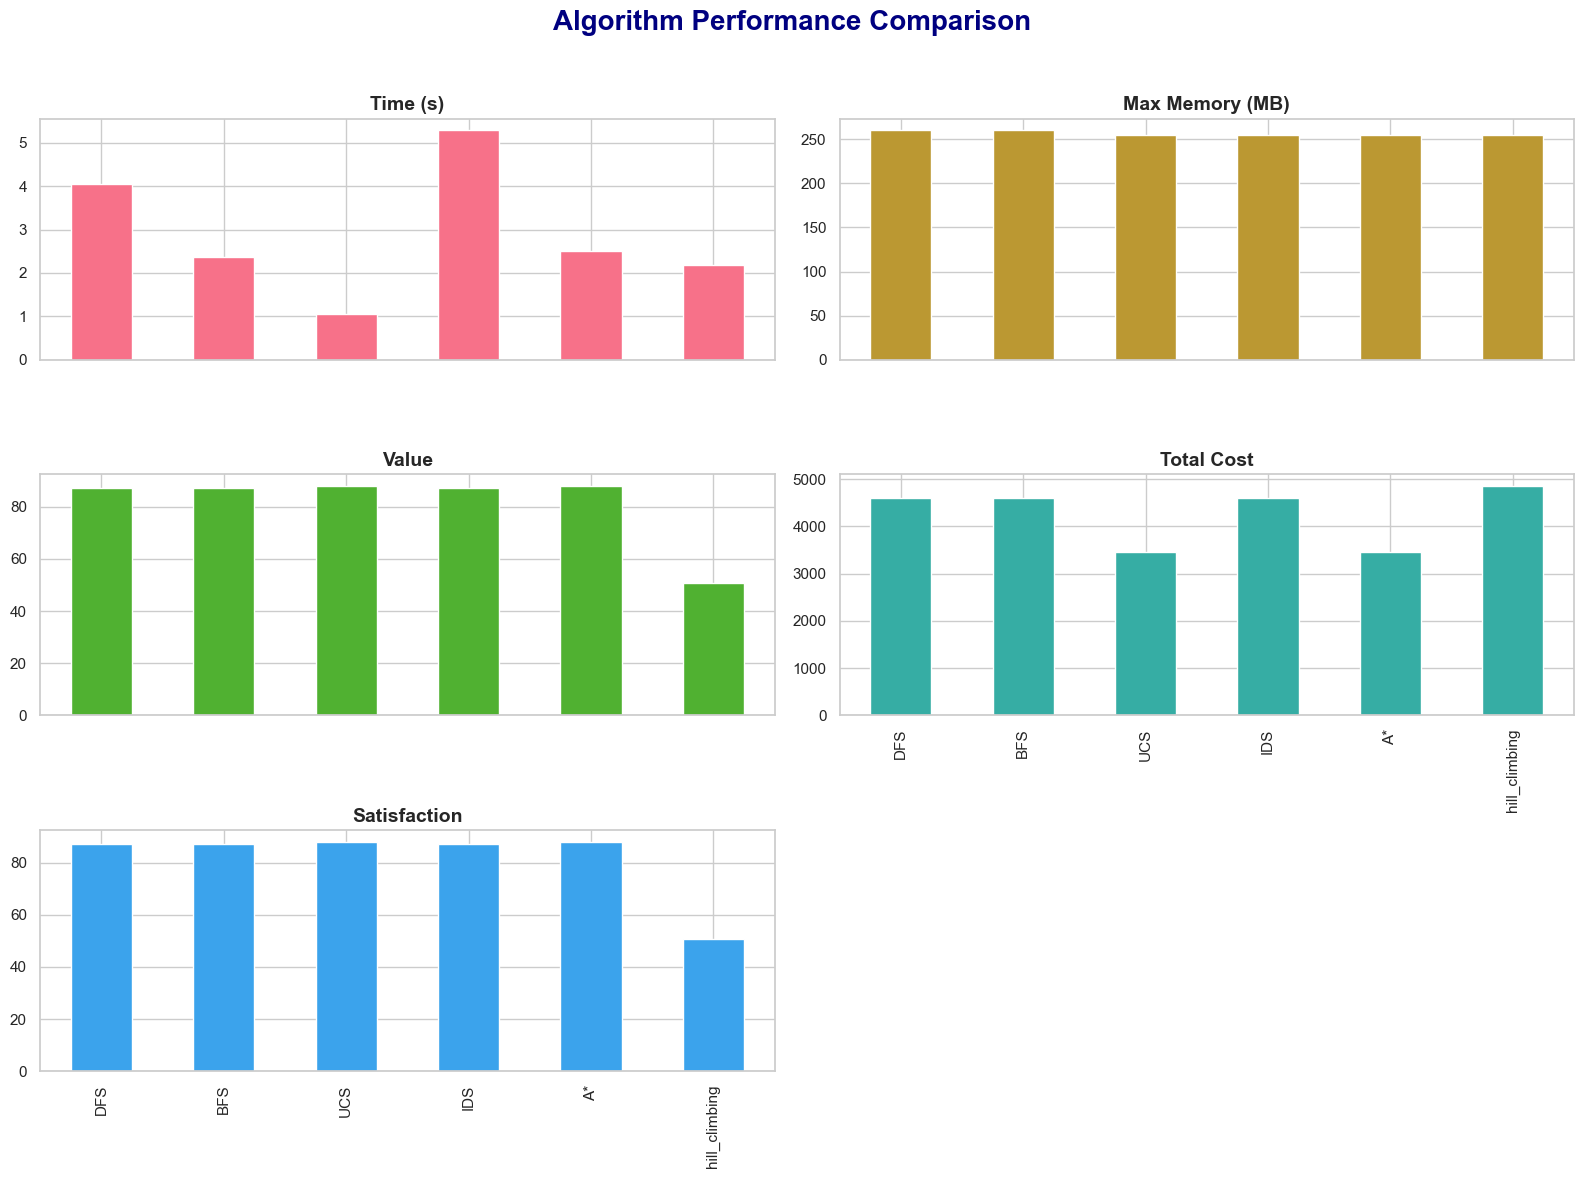

──────────────────────────────────────── 🧠 Algorithm Complexity Analysis ─────────────────────────────────────────

╒═════════════════════╤═══════════════════╤════════════════════╤═══════════╤════════════╕
│ Algorithm           │ Time Complexity   │ Space Complexity   │ Optimal   │ Complete   │
╞═════════════════════╪═══════════════════╪════════════════════╪═══════════╪════════════╡
│ BFS                 │ O(b^d)            │ O(b^d)             │ Yes       │ Yes        │
├─────────────────────┼───────────────────┼────────────────────┼───────────┼────────────┤
│ DFS                 │ O(b^m)            │ O(bm)              │ No        │ No         │
├─────────────────────┼───────────────────┼────────────────────┼───────────┼────────────┤
│ Iterative Deepening │ O(b^d)            │ O(bd)              │ Yes       │ Yes        │
├─────────────────────┼───────────────────┼────────────────────┼───────────┼────────────┤
│ Uniform Cost        │ O(b^(1+C/ε))      │ O(b^(1+C/ε))       │ Yes       │ Yes        │
├─────────────────────┼───────────────────┼────────────────────┼───────────┼────────────┤
│ A*      

─────────────────────────────────────────── 💡 Strengths and Weaknesses ───────────────────────────────────────────

╒═════════════════════╤═════════════════════════════════════════════════╤════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╕
│                     │ Strengths                                       │ Weaknesses                                 │ Best Use Case                                             │
╞═════════════════════╪═════════════════════════════════════════════════╪════════════════════════════════════════════╪═══════════════════════════════════════════════════════════╡
│ BFS                 │ Guarantees optimal solution, complete           │ High memory usage, slow for large problems │ Small problems where optimality is critical               │
├─────────────────────┼─────────────────────────────────────────────────┼────────────────────────────────────────────┼───────────────────────────────────────────────────────────┤
│ DFS                 │ Low memory usage, fast for some problems        │ Not optimal, may get stuck in d

──────────────────────────────────────────── ✅ Final Recommendations ─────────────────────────────────────────────

    1. 🧩 For small problems (<50 attractions): BFS or Iterative Deepening
    2. 🧠 For medium problems with good heuristic: A*
    3. 🚀 For large problems where optimality isn't critical: Hill Climbing
    4. 💾 When memory is constrained: DFS or Hill Climbing
    5. 💰 When costs vary significantly: Uniform Cost Search
    

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import numpy as np
from tabulate import tabulate
from rich.console import Console
import seaborn as sns
import sys
import io

def generate_academic_report():
    """Generate a formal academic analysis of the algorithms' performance in tour planning."""
    console.rule("[bold blue]📚how each Search Algorithm works in Tour Planning")
    
    analysis = """
This section provides a formal discussion of how each search algorithm operates within the context of the tour planning problem, where the goal is to optimize an itinerary given constraints (budget, time, preferences).

## 1. Breadth-First Search (BFS)
BFS explores all nodes at the present depth level before moving to nodes at the next depth. It uses a queue to manage frontier nodes.

### Application to Tour Planning
- Optimality: Guarantees the shortest path if all steps have equal cost
- Completeness: Always finds a solution if one exists
- Limitations: High memory usage (O(b^d)), impractical for large datasets

## 2. Depth-First Search (DFS)
DFS explores as far as possible along a branch before backtracking, using a stack (LIFO).

### Application to Tour Planning
- Memory Efficiency: Only stores current path (O(bm))
- Drawbacks: Not optimal, may find suboptimal solutions
- Risk: Can get stuck in deep paths without finding better solutions

## 3. Iterative Deepening Search (IDS)
Combines BFS and DFS by performing DFS with incrementally increasing depth limits.

### Application to Tour Planning
- Optimality: Like BFS, guarantees shortest path
- Memory Efficiency: Only stores nodes at current depth (O(bd))
- Trade-off: Repeats work but avoids memory explosion

## 4. Uniform Cost Search (UCS)
Prioritizes nodes with lowest path cost using a priority queue.

### Application to Tour Planning
- Optimality: Guarantees lowest-cost itinerary
- Complexity: O(b^(1+C/ε)) where C is optimal cost
- Best for: Cost-sensitive planning with varying attraction costs

## 5. A* Search
Extends UCS with heuristic function (h(n)) to estimate remaining cost.

### Application to Tour Planning
- Heuristic Example: (remaining_budget / max_cost_per_attraction)
- Optimality: Guaranteed with admissible heuristic
- Efficiency: Explores fewer nodes than UCS with good heuristic

## 6. Hill Climbing (with Restarts)
Local search that moves to neighboring states with higher value.

### Application to Tour Planning
- Strengths: Low memory (O(1)), fast convergence
- Weaknesses: Gets stuck in local optima
- Best for: Large problems where near-optimal is acceptable

"""
    
    console.print(analysis, style="bold white")


def run_algorithm(algorithm, problem):
    """Run an algorithm and measure its performance metrics."""
    start_time = time.time()

    # Define a wrapper to correctly call the algorithm with proper args
    def wrapped_algo():
        if algorithm.__name__ == 'BFS':
            return algorithm(problem, hotels_data, attractions_data)
        elif algorithm.__name__ in ['depth_first_search', 'iterative_deepening_search']:
            return algorithm(problem, max_depth=40)
        else:
            return algorithm(problem)

    if algorithm.__name__ == 'hill_climbing':
        # 🌟 Silence hill climbing output
        sys_stdout = sys.stdout
        sys.stdout = io.StringIO()

        try:
            # Profile memory usage
            mem_usage = memory_usage((wrapped_algo,), interval=0.1)
            avg_mem = sum(mem_usage) / len(mem_usage)
            max_mem = max(mem_usage)
            solution = wrapped_algo()
        finally:
            sys.stdout = sys_stdout  # Restore normal stdout

    else:
        # Normal for other algorithms
        mem_usage = memory_usage((wrapped_algo,), interval=0.1)
        avg_mem = sum(mem_usage) / len(mem_usage)
        max_mem = max(mem_usage)
        solution = wrapped_algo()

    exec_time = time.time() - start_time

    if solution:
        if algorithm.__name__ == 'hill_climbing':
            solution_state = solution[0] if isinstance(solution, tuple) else solution
            return {
                'solution': solution,
                'time': exec_time,
                'avg_memory': avg_mem,
                'max_memory': max_mem,
                'cost': solution_state['total_cost'],
                'days_used': solution_state['curr_day'],
                'satisfaction': problem._calculate_satisfaction(solution_state),
                'penalties': problem._calculate_penalties(solution_state),
                'value': problem.value(solution_state),
                'nodes_expanded': None,
                'frontier_size': None
            }
        else:
            return {
                'solution': solution,
                'time': exec_time,
                'avg_memory': avg_mem,
                'max_memory': max_mem,
                'cost': solution.state['total_cost'],
                'days_used': solution.state['curr_day'],
                'satisfaction': problem._calculate_satisfaction(solution.state),
                'penalties': problem._calculate_penalties(solution.state),
                'value': problem.value(solution.state),
                'nodes_expanded': getattr(solution, 'nodes_expanded', None),
                'frontier_size': getattr(solution, 'max_frontier', None)
            }
    return None


console = Console()

def compare_algorithms(attractions_data):
    """Compare multiple algorithms for the tour planning problem with modern visuals."""
    constraints = {
        "max_total_budget": 5000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 1,
        "has_car": True,
    }
    user_prefs = {"categories": ["Museum"]}

    initial_state = {
        "current_location": (36.737232, 3.086472),   # Constantine
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7
    }

    # Build problem
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints
    )

    algorithms = [
        ('DFS', depth_first_search),
        ('BFS', BFS),
        ('UCS', uniform_cost_search),
        ('IDS', iterative_deepening_search),
        ('A*', a_star_search),
        ('hill_climbing', hill_climbing_with_restarts)
    ]

    results = []
    print("Running comparisons...")
    for name, algo in algorithms:
        print(f"\n{name}...")
        result = run_algorithm(algo, problem)
        if result:
            results.append({
                'Algorithm': name,
                'Time (s)': result['time'],
                'Avg Memory (MB)': result['avg_memory'],
                'Max Memory (MB)': result['max_memory'],
                'Total Cost': result['cost'],
                'Days Used': result['days_used'],
                'Satisfaction': result['satisfaction'],
                'Penalties': result['penalties'],
                'Value': result['value'],
            })
        else:
            results.append({
                'Algorithm': name,
                'Time (s)': np.nan,
                'Avg Memory (MB)': np.nan,
                'Max Memory (MB)': np.nan,
                'Total Cost': np.nan,
                'Days Used': np.nan,
                'Satisfaction': np.nan,
                'Penalties': np.nan,
                'Value': np.nan,
            })

    # Create DataFrame
    df = pd.DataFrame(results).set_index('Algorithm')

    # 🌟 Modern Table Display
    console.rule("[bold cyan]📊 Results Table")
    print(tabulate(df.round(2), headers='keys', tablefmt='fancy_grid'))

    # Plotting
    numeric_columns = ['Time (s)', 'Max Memory (MB)', 'Value', 'Total Cost', 'Satisfaction', 'Penalties']
    
    if df[numeric_columns].dropna(how='all').empty:
        console.print("\n[bold red]⚠️ No valid numeric data to plot.[/bold red]")
        return

    sns.set_theme(style="whitegrid")
    custom_palette = sns.color_palette("husl", len(df))

    # Main performance metrics plot - now with 6 subplots (3 rows × 2 columns)
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()  # Flatten the 3x2 array of axes for easier iteration

    for i, metric in enumerate(numeric_columns):
        ax = axes[i]
        df[metric].plot(kind='bar', ax=ax, color=custom_palette)
        ax.set_title(metric, fontsize=14, fontweight='bold')
        ax.set_xlabel("")
        
        # Add value labels on top of bars
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(p.get_x() + p.get_width() / 2., height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10)

    # Hide any empty subplots if we have an odd number
    if len(numeric_columns) < len(axes):
        for j in range(len(numeric_columns), len(axes)):
            axes[j].axis('off')

    plt.suptitle("Algorithm Performance Comparison", fontsize=20, fontweight='bold', color='navy')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    
    
    # Add value labels on top of bars
   

    # 🌟 Algorithm Complexity Analysis
    console.rule("[bold green]🧠 Algorithm Complexity Analysis")
    complexity_data = {
        'Algorithm': ['BFS', 'DFS', 'Iterative Deepening', 'Uniform Cost', 'A*', 'Hill Climbing'],
        'Time Complexity': ['O(b^d)', 'O(b^m)', 'O(b^d)', 'O(b^(1+C/ε))', 'O(b^d)', 'O(n)'],
        'Space Complexity': ['O(b^d)', 'O(bm)', 'O(bd)', 'O(b^(1+C/ε))', 'O(b^d)', 'O(1)'],
        'Optimal': ['Yes', 'No', 'Yes', 'Yes', 'Yes', 'No'],
        'Complete': ['Yes', 'No', 'Yes', 'Yes', 'Yes', 'No']
    }
    complexity_df = pd.DataFrame(complexity_data).set_index('Algorithm')
    print(tabulate(complexity_df, headers='keys', tablefmt='fancy_grid'))
    
    # 🌟 Radar Chart Visualization
    console.rule("[bold purple]📈 Radar Chart Comparison")
    
    # Select metrics for radar chart (normalized to 0-1 scale)
    radar_metrics = ['Time (s)', 'Max Memory (MB)', 'Value', 'Satisfaction', 'Penalties']
    radar_df = df[radar_metrics].copy()
    
    # Normalize data (lower time/memory is better, higher value/satisfaction is better, lower penalties is better)
    for metric in radar_metrics:
        if metric in ['Time (s)', 'Max Memory (MB)', 'Penalties']:
            radar_df[metric] = 1 - (radar_df[metric] / radar_df[metric].max())
        else:
            radar_df[metric] = radar_df[metric] / radar_df[metric].max()
    
    # Number of variables we're plotting
    categories = list(radar_df.columns)
    N = len(categories)
    
    # Calculate angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    
    # Initialize radar chart
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    
    # Set the first axis to be on top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
    plt.ylim(0, 1.1)
    
    # Plot each algorithm
    colors = sns.color_palette("husl", len(radar_df))
    for idx, (algo, row) in enumerate(radar_df.iterrows()):
        values = row.values.flatten().tolist()
        values += values[:1]  # Complete the loop
        ax.plot(angles, values, color=colors[idx], linewidth=2, linestyle='solid', label=algo)
        ax.fill(angles, values, color=colors[idx], alpha=0.1)
    
    # Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title("Algorithm Performance Radar Chart\n(Normalized metrics, higher is better)", 
              size=16, color='navy', y=1.1)
    
    plt.tight_layout()
    plt.show()
    
    # 🌟 Strengths and Weaknesses
    console.rule("[bold yellow]💡 Strengths and Weaknesses")
    analysis = {
        'BFS': {
            'Strengths': 'Guarantees optimal solution, complete',
            'Weaknesses': 'High memory usage, slow for large problems',
            'Best Use Case': 'Small problems where optimality is critical'
        },
        'DFS': {
            'Strengths': 'Low memory usage, fast for some problems',
            'Weaknesses': 'Not optimal, may get stuck in deep paths',
            'Best Use Case': 'When memory is constrained and solution depth is known'
        },
        'Iterative Deepening': {
            'Strengths': 'Optimal like BFS but with better memory usage',
            'Weaknesses': 'Repeats work at each iteration',
            'Best Use Case': 'When solution depth is unknown but optimality is needed'
        },
        'Uniform Cost': {
            'Strengths': 'Optimal for path cost, good for weighted graphs',
            'Weaknesses': 'Higher memory usage than greedy algorithms',
            'Best Use Case': 'When costs vary significantly between steps'
        },
        'A*': {
            'Strengths': 'Optimal and efficient with good heuristic',
            'Weaknesses': 'Requires domain-specific heuristic',
            'Best Use Case': 'When you have a good heuristic function'
        },
        'Hill Climbing': {
            'Strengths': 'Very fast, low memory usage',
            'Weaknesses': 'Gets stuck in local optima, not optimal',
            'Best Use Case': 'Large problems where a good-enough solution is acceptable'
        }
    }
    analysis_df = pd.DataFrame(analysis).T
    print(tabulate(analysis_df, headers='keys', tablefmt='fancy_grid'))
    generate_academic_report()

attractions_data = load_attractions("../Data/attractions.json")
compare_algorithms(attractions_data)

## Visualizations

We will include several visualizations to help understand the results:
- **Route Map**: Visualize the itinerary on a map.
- **Cost Breakdown**: Graph showing the total cost per destination.
- **Satisfaction**: Bar chart comparing user satisfaction for different search strategies.


In [ ]:
import matplotlib.pyplot as plt

# Example plot for the cost breakdown
def plot_cost_breakdown(itinerary, attractions):
    costs = [attractions[a]['cost'] for a in itinerary]
    plt.bar(range(len(itinerary)), costs)
    plt.xlabel('Attraction')
    plt.ylabel('Cost')
    plt.title('Cost Breakdown')
    plt.show()

## Demo

In this section, we will showcase the working prototype of the **Touristic Tour Recommendation Application**. This demo will cover:
- The **interactive input** from the user (e.g., preferences, current location, etc.).
- Displaying the **optimized itinerary** generated by the selected search algorithm.
- Visualizations of the **travel route**, **cost breakdown**, and **satisfaction level**.

In [ ]:
pass

## Conclusion

In this notebook, we explored different search algorithms (A\*, Hill Climbing, BFS, DFS) and a CSP approach to generate optimal itineraries for travelers in Algeria. 
We found that **.....** performed well in terms of solution quality, but it was more computationally expensive compared to **.....**. 
Future work could involve integrating real-time weather data and optimizing routes based on current traffic conditions.
